# Config

In [52]:
import os

import SimpleITK as sitk
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from imblearn.over_sampling import RandomOverSampler
from pyfume import pyFUME, Clusterer, AntecedentEstimator, FireStrengthCalculator, ConsequentEstimator, \
    SugenoFISBuilder, SugenoFISTester
from radiomics import featureextractor
from scipy.stats import mannwhitneyu
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [53]:
# Paths to the folders with images and masks
input_folder = os.path.join("dataset")  #contains the csv of the data
image_folder = os.path.join(input_folder, "cut")
mask_folder = os.path.join(input_folder, "mask_7000")  #choose the desired mask

# Define Segmentation Model and Segmentation Function

In [54]:
def visualize(image, mask, title="Image and Mask"):
    """Visualize the original image and its corresponding mask."""
    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # Display the original image in the first subplot
    axs[0].imshow(sitk.GetArrayFromImage(image), cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Display the mask image in the second subplot
    axs[1].imshow(mask * 255, cmap='gray')
    axs[1].set_title('Generated Mask')
    axs[1].axis('off')

    # Display the mask multiplied by the original image in the third subplot
    axs[2].imshow(mask * sitk.GetArrayFromImage(image), cmap='gray')
    axs[2].set_title('Mask*image')
    axs[2].axis('off')

    # Add a suptitle to the figure
    plt.suptitle(title)
    plt.show()


def load_image_and_create_mask(image_path, mask_path, vis=False):
    """Load image, create and visualize mask."""
    # Print the path of the image being loaded
    print("Loading image {}".format(image_path))

    # Read the image using SimpleITK
    image = sitk.ReadImage(image_path, sitk.sitkFloat32)
    image_np = sitk.GetArrayFromImage(image)

    # Read the mask image using OpenCV
    mask_np = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

    # Resize mask to match image size
    mask_np = cv.resize(mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv.INTER_NEAREST)

    # Convert the mask image to a binary image
    ret, mask_np = cv.threshold(mask_np, 127, 255, cv.THRESH_BINARY)
    mask_np = (mask_np > 0).astype(np.uint8)  # Convert to binary mask

    # If visualization is enabled, visualize the image and mask
    if vis:
        visualize(image, mask_np)

    # Convert the NumPy mask to a SimpleITK image and copy the metadata
    mask = sitk.GetImageFromArray(mask_np)
    mask.CopyInformation(image)

    # Return the loaded image and created mask
    return image, mask


# Initialize the radiomics feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

# Extract Features and Prepare Dataset

In [55]:
def extract_features(image, mask):
    """Extract radiomic features from the image and mask."""
    # Execute the feature extraction using the initialized extractor
    result = extractor.execute(image, mask)
    # Get only the feature values after skipping the first 22 meta entries
    features = {k: result[k] for k in list(result.keys())[22:]}  # Adjust indices as necessary
    return features


def prepare_dataset(folder_path):
    """Prepare dataset by extracting features from images and masks, and organizing them into a feature vector."""
    feature_vector = []
    labels = []
    groups = []
    feature_names = None

    # Read the CSV file containing metadata
    df = pd.read_csv(os.path.join(folder_path, "data.csv"), sep=';', header=0)
    # Dictionary that maps class id to name
    class_names = ['healthy', 'affected']
    id2name = {idx: name for idx, name in enumerate(class_names)}

    # Iterate over each row in the dataframe
    for idx, row in df.iterrows():
        # Construct paths to the image and mask files
        image_path = os.path.join(image_folder, id2name[row['labels']], row['img'])
        mask_path = os.path.join(mask_folder, id2name[row['labels']], row['img'])

        # Load the image and create the mask
        image, mask = load_image_and_create_mask(image_path, mask_path)
        # Extract features from the image and mask
        features = extract_features(image, mask)

        # Store feature names once, when they are first encountered
        if feature_names is None:
            feature_names = list(features.keys())

        # Append the extracted features, label, and group to their respective lists
        feature_vector.append(list(features.values()))
        labels.append(row['labels'])
        groups.append(row['groups'])

    # Convert lists to numpy arrays for easier manipulation
    feature_vector = np.array(feature_vector)
    labels = np.array(labels)
    groups = np.array(groups)

    # Return the feature vector, labels, groups, and feature names
    return feature_vector, labels, groups, feature_names


# Unit Test





Loading image dataset/cut/healthy/IM-0005-0023-h5-2.jpg


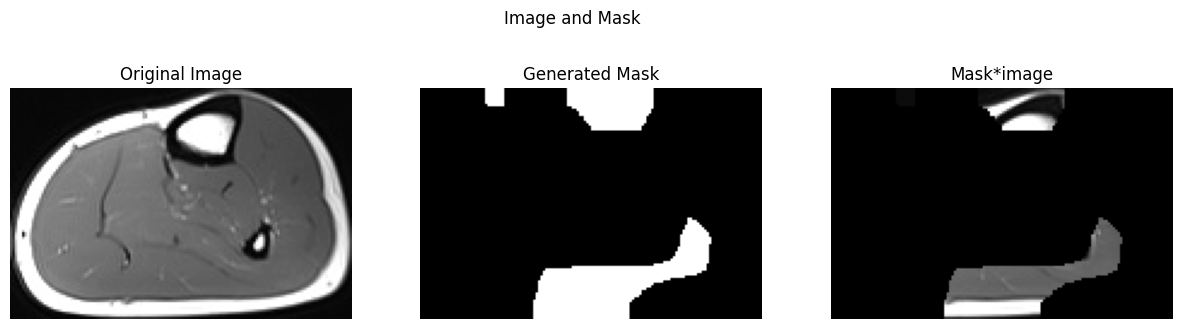

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0005-0022-h5-2.jpg


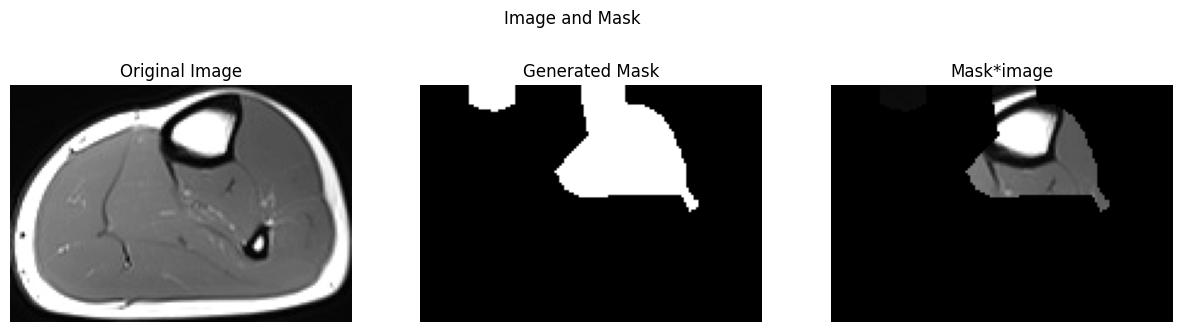

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0009-0005-h4-1.jpg


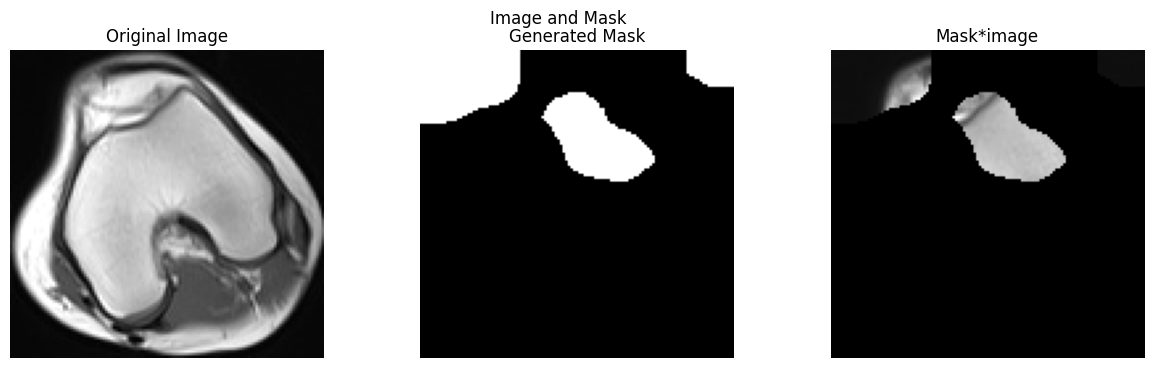

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0009-0027-h-2.jpg


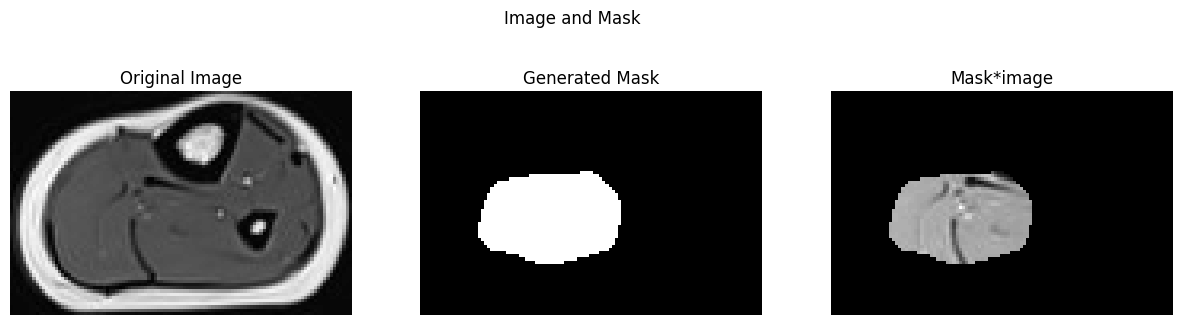

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0027-h5-2.jpg


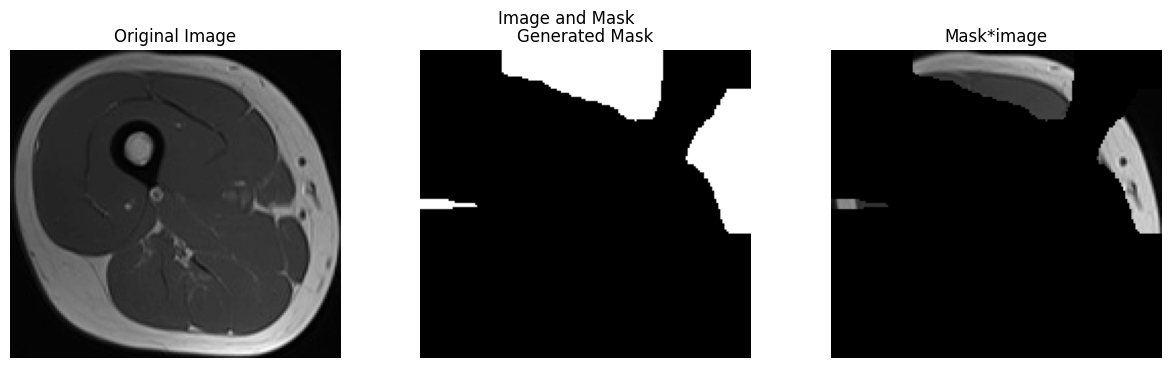

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [56]:
# Example of selective visualization
folder_path = os.path.join(image_folder, 'healthy')

# Loop through the files in the folder and visualize the first 5 images and masks
for idx, filename in enumerate(os.listdir(folder_path)):
    # Break the loop after visualizing 5 images
    if idx >= 5:
        break

    # Construct the full path to the image and mask files
    full_path_image = os.path.join(image_folder, 'healthy', filename)
    full_path_mask = os.path.join(mask_folder, 'healthy', filename)

    # Load the image and create the mask, with visualization enabled
    image, mask = load_image_and_create_mask(image_path=full_path_image, mask_path=full_path_mask, vis=True)

    # Extract features from the image and mask
    features = extract_features(image, mask)


# Create Dataset

In [57]:
# Extracting features and labels from both folders
X, y, groups, feature_names = prepare_dataset(input_folder)

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0001-0004-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0005-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0006-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0007-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0007-6-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0001-0008-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0008-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0009-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0009-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0010-4-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0001-0010-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0011-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0011-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0011-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0011-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0012-4-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0001-0012-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0013-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0013-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0013-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0013-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0014-4-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0001-0014-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0014-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0014-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0015-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0015-4-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/affected/IM-0001-0015-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0015-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0016-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0016-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0016-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0016-6-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/affected/IM-0001-0017-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0017-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0017-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0017-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0018-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0018-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0018-6-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/affected/IM-0001-0018-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0019-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0019-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0019-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0019-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0020-4-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/affected/IM-0001-0020-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0020-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0020-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0021-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0021-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0021-6-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0001-0021-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0022-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0022-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0022-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0022-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0023-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0023-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0023-6-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0001-0023-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0024-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0024-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0024-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0024-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0025-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0025-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0025-6-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/affected/IM-0001-0025-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0026-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0026-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0026-6-1.jpg
Loading image dataset/cut/affected/IM-0001-0026-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0027-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0027-4-2.jpg
Loading image dataset/cut/affected/IM-0001-0027-6-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0001-0027-6-2.jpg
Loading image dataset/cut/affected/IM-0001-0028-4-1.jpg
Loading image dataset/cut/affected/IM-0001-0028-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0001-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0001-4-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0003-0002-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0002-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0003-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0003-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0004-4-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0003-0004-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0004-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0005-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0003-0005-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0005-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0005-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0006-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0006-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0006-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0006-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0006-5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0007-1.jpg
Loading image dataset/cut/affected/IM-0003-0007-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0007-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0007-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0007-5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0007-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0007-6-2.jpg
Loading image dataset/cut/affected/IM-0003-0008-1.jpg
Loading image dataset/cut/affected/IM-0003-0008-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0008-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0008-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0008-5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0008-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0008-6-2.jpg
Loading image dataset/cut/affected/IM-0003-0009-1.jpg
Loading image dataset/cut/affected/IM-0003-0009-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0009-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0009-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0009-5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0009-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0009-6-2.jpg
Loading image dataset/cut/affected/IM-0003-0010-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0010-1.jpg
Loading image dataset/cut/affected/IM-0003-0010-2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0010-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0010-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0010-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0010-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0010-6-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0010-6-2.jpg
Loading image dataset/cut/affected/IM-0003-0011-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0011-1.jpg
Loading image dataset/cut/affected/IM-0003-0011-2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0011-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0011-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0011-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0011-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0011-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0011-6-2.jpg
Loading image dataset/cut/affected/IM-0003-0012-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0012-1.jpg
Loading image dataset/cut/affected/IM-0003-0012-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0012-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0012-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0012-4-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0012-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0012-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0012-6-2.jpg
Loading image dataset/cut/affected/IM-0003-0013-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0013-1.jpg
Loading image dataset/cut/affected/IM-0003-0013-2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0013-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0013-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0013-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0013-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0013-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0013-6-2.jpg
Loading image dataset/cut/affected/IM-0003-0014-1-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0014-1.jpg
Loading image dataset/cut/affected/IM-0003-0014-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0014-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0014-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0014-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0014-5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0014-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0014-6-2.jpg
Loading image dataset/cut/affected/IM-0003-0015-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0015-1.jpg
Loading image dataset/cut/affected/IM-0003-0015-2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0015-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0015-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0015-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0015-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0015-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0015-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0015-6-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0016-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0016-1.jpg
Loading image dataset/cut/affected/IM-0003-0016-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0016-3-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0016-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0016-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0016-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0016-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0016-6-2.jpg
Loading image dataset/cut/affected/IM-0003-0017-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0003-0017-1.jpg
Loading image dataset/cut/affected/IM-0003-0017-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0017-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0017-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0017-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0017-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0017-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0017-5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0017-5-2.jpg
Loading image dataset/cut/affected/IM-0003-0017-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0017-6-2.jpg
Loading image dataset/cut/affected/IM-0003-0018-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0018-1.jpg
Loading image dataset/cut/affected/IM-0003-0018-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0018-3-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0018-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0018-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0018-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0018-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0018-5-2.jpg
Loading image dataset/cut/affected/IM-0003-0018-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0018-6-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0003-0019-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0019-1-2.jpg
Loading image dataset/cut/affected/IM-0003-0019-1.jpg
Loading image dataset/cut/affected/IM-0003-0019-2-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/affected/IM-0003-0019-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0019-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0019-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0019-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0019-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0019-5-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/affected/IM-0003-0019-6-1.jpg
Loading image dataset/cut/affected/IM-0003-0019-6-2.jpg
Loading image dataset/cut/affected/IM-0003-0020-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0020-1-2.jpg
Loading image dataset/cut/affected/IM-0003-0020-1.jpg
Loading image dataset/cut/affected/IM-0003-0020-2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0020-2.jpg
Loading image dataset/cut/affected/IM-0003-0020-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0020-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0020-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0020-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0020-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0020-5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0003-0021-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0021-1-2.jpg
Loading image dataset/cut/affected/IM-0003-0021-1.jpg
Loading image dataset/cut/affected/IM-0003-0021-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0021-2-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/affected/IM-0003-0021-2.jpg
Loading image dataset/cut/affected/IM-0003-0021-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0021-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0021-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0021-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0021-5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0003-0021-5-2.jpg
Loading image dataset/cut/affected/IM-0003-0022-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0022-1-2.jpg
Loading image dataset/cut/affected/IM-0003-0022-1.jpg
Loading image dataset/cut/affected/IM-0003-0022-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0022-2-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/affected/IM-0003-0022-2.jpg
Loading image dataset/cut/affected/IM-0003-0022-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0022-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0022-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0022-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0022-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0022-5-2.jpg
Loading image dataset/cut/affected/IM-0003-0023-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0023-1-2.jpg
Loading image dataset/cut/affected/IM-0003-0023-1.jpg
Loading image dataset/cut/affected/IM-0003-0023-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0023-2-2.jpg
Loading image dataset/cut/affected/IM-0003-0023-2.jpg
Loading image dataset/cut/affected/IM-0003-0023-3-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/affected/IM-0003-0023-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0023-4-1.jpg
Loading image dataset/cut/affected/IM-0003-0023-4-2.jpg
Loading image dataset/cut/affected/IM-0003-0023-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0023-5-2.jpg
Loading image dataset/cut/affected/IM-0003-0024-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0024-1-2.jpg
Loading image dataset/cut/affected/IM-0003-0024-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0024-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0024-2-2.jpg
Loading image dataset/cut/affected/IM-0003-0024-2.jpg
Loading image dataset/cut/affected/IM-0003-0024-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0024-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0024-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0024-5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0003-0025-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0025-1-2.jpg
Loading image dataset/cut/affected/IM-0003-0025-1.jpg
Loading image dataset/cut/affected/IM-0003-0025-2-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0025-2-2.jpg
Loading image dataset/cut/affected/IM-0003-0025-2.jpg
Loading image dataset/cut/affected/IM-0003-0025-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0025-3-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0003-0025-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0025-5-2.jpg
Loading image dataset/cut/affected/IM-0003-0026-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0026-1-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0026-1.jpg
Loading image dataset/cut/affected/IM-0003-0026-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0026-2-2.jpg
Loading image dataset/cut/affected/IM-0003-0026-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0026-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0026-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0026-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0026-5-2.jpg
Loading image dataset/cut/affected/IM-0003-0027-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0027-1-2.jpg
Loading image dataset/cut/affected/IM-0003-0027-1.jpg
Loading image dataset/cut/affected/IM-0003-0027-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0027-2-2.jpg
Loading image dataset/cut/affected/IM-0003-0027-2.jpg
Loading image dataset/cut/affected/IM-0003-0027-3-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0027-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0027-5-1.jpg
Loading image dataset/cut/affected/IM-0003-0027-5-2.jpg
Loading image dataset/cut/affected/IM-0003-0028-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0028-1-2.jpg
Loading image dataset/cut/affected/IM-0003-0028-1.jpg
Loading image dataset/cut/affected/IM-0003-0028-2-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/affected/IM-0003-0028-2-2.jpg
Loading image dataset/cut/affected/IM-0003-0028-2.jpg
Loading image dataset/cut/affected/IM-0003-0028-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0028-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0029-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0029-1-2.jpg
Loading image dataset/cut/affected/IM-0003-0029-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0029-2-1.jpg
Loading image dataset/cut/affected/IM-0003-0029-2-2.jpg
Loading image dataset/cut/affected/IM-0003-0029-2.jpg
Loading image dataset/cut/affected/IM-0003-0029-3-1.jpg
Loading image dataset/cut/affected/IM-0003-0029-3-2.jpg
Loading image dataset/cut/affected/IM-0003-0030-1-1.jpg
Loading image dataset/cut/affected/IM-0003-0030-1-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0003-0030-1.jpg
Loading image dataset/cut/affected/IM-0003-0030-2.jpg
Loading image dataset/cut/affected/IM-0003-0031-1.jpg
Loading image dataset/cut/affected/IM-0003-0031-2.jpg
Loading image dataset/cut/affected/IM-0003-0032-1.jpg
Loading image dataset/cut/affected/IM-0003-0032-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0003-0033-1.jpg
Loading image dataset/cut/affected/IM-0003-0033-2.jpg
Loading image dataset/cut/affected/IM-0005-0003-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0003-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0004-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0004-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0004-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0004-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0005-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0005-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0005-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0005-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0006-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0006-1-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0006-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0006-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0007-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0007-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0007-3-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0007-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0008-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0008-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0008-3-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0008-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0009-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0009-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0009-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0009-3-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0010-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0010-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0010-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0010-3-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0011-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0011-1-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0011-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0011-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0012-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0012-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0012-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0012-3-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0013-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0013-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0013-3-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0013-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0014-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0014-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0014-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0014-3-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0005-0015-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0015-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0015-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0015-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0016-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0016-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0016-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0016-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0017-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0017-1-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0017-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0017-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0018-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0018-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0018-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0018-3-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0005-0019-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0019-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0019-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0019-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0020-1-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0020-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0020-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0020-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0021-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0021-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0021-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0021-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0022-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0022-1-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0005-0022-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0022-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0023-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0023-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0023-3-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0023-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0024-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0024-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0024-3-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/affected/IM-0005-0024-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0025-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0025-1-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0025-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0025-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0026-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0026-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0026-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0026-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0027-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0005-0027-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0027-3-1.jpg
Loading image dataset/cut/affected/IM-0005-0027-3-2.jpg
Loading image dataset/cut/affected/IM-0005-0028-1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0005-0028-1-2.jpg
Loading image dataset/cut/affected/IM-0005-0029-1-1.jpg
Loading image dataset/cut/affected/IM-0005-0029-1-2.jpg
Loading image dataset/cut/affected/IM-0009-0004-1.jpg
Loading image dataset/cut/affected/IM-0009-0004-2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0004-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0004-2.jpg
Loading image dataset/cut/affected/IM-0009-0004-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0004-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0005-1.jpg
Loading image dataset/cut/affected/IM-0009-0005-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0005-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0005-2.jpg
Loading image dataset/cut/affected/IM-0009-0005-5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0005-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0006-1.jpg
Loading image dataset/cut/affected/IM-0009-0006-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0006-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0006-2.jpg
Loading image dataset/cut/affected/IM-0009-0006-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0006-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0007-1.jpg
Loading image dataset/cut/affected/IM-0009-0007-2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0007-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0007-2.jpg
Loading image dataset/cut/affected/IM-0009-0007-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0007-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0008-1.jpg
Loading image dataset/cut/affected/IM-0009-0008-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0008-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0008-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0008-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0008-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0009-1.jpg
Loading image dataset/cut/affected/IM-0009-0009-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0009-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0009-2.jpg
Loading image dataset/cut/affected/IM-0009-0009-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0009-5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0010-1.jpg
Loading image dataset/cut/affected/IM-0009-0010-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0010-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0010-2.jpg
Loading image dataset/cut/affected/IM-0009-0010-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0010-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0011-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0011-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0011-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0011-2.jpg
Loading image dataset/cut/affected/IM-0009-0011-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0011-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0012-1.jpg
Loading image dataset/cut/affected/IM-0009-0012-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0012-2-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0012-2.jpg
Loading image dataset/cut/affected/IM-0009-0012-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0012-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0013-1.jpg
Loading image dataset/cut/affected/IM-0009-0013-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0013-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0013-2.jpg
Loading image dataset/cut/affected/IM-0009-0013-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0013-5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0014-1.jpg
Loading image dataset/cut/affected/IM-0009-0014-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0014-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0014-2.jpg
Loading image dataset/cut/affected/IM-0009-0014-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0014-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0015-1.jpg
Loading image dataset/cut/affected/IM-0009-0015-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0015-2-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0015-2.jpg
Loading image dataset/cut/affected/IM-0009-0015-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0015-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0016-1.jpg
Loading image dataset/cut/affected/IM-0009-0016-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0016-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0016-2.jpg
Loading image dataset/cut/affected/IM-0009-0016-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0016-5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0017-1.jpg
Loading image dataset/cut/affected/IM-0009-0017-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0017-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0017-2.jpg
Loading image dataset/cut/affected/IM-0009-0017-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0017-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0018-1.jpg
Loading image dataset/cut/affected/IM-0009-0018-2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0018-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0018-2.jpg
Loading image dataset/cut/affected/IM-0009-0018-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0018-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0019-1.jpg
Loading image dataset/cut/affected/IM-0009-0019-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0019-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0019-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0019-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0019-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0020-1.jpg
Loading image dataset/cut/affected/IM-0009-0020-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0020-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0020-2.jpg
Loading image dataset/cut/affected/IM-0009-0020-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0020-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0021-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0021-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0021-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0021-2.jpg
Loading image dataset/cut/affected/IM-0009-0021-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0021-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0022-1.jpg
Loading image dataset/cut/affected/IM-0009-0022-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0022-2-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0009-0022-2.jpg
Loading image dataset/cut/affected/IM-0009-0022-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0022-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0023-1.jpg
Loading image dataset/cut/affected/IM-0009-0023-2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0009-0023-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0023-2.jpg
Loading image dataset/cut/affected/IM-0009-0023-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0023-5-2.jpg
Loading image dataset/cut/affected/IM-0009-0024-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/affected/IM-0009-0024-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0024-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0024-2.jpg
Loading image dataset/cut/affected/IM-0009-0024-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0024-5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0025-1.jpg
Loading image dataset/cut/affected/IM-0009-0025-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0025-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0025-2.jpg
Loading image dataset/cut/affected/IM-0009-0025-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0025-5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0026-1.jpg
Loading image dataset/cut/affected/IM-0009-0026-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0026-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0026-2.jpg
Loading image dataset/cut/affected/IM-0009-0026-5-1.jpg
Loading image dataset/cut/affected/IM-0009-0026-5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0027-1.jpg
Loading image dataset/cut/affected/IM-0009-0027-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0027-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0027-2.jpg
Loading image dataset/cut/affected/IM-0009-0028-1.jpg
Loading image dataset/cut/affected/IM-0009-0028-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0028-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0028-2.jpg
Loading image dataset/cut/affected/IM-0009-0029-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/affected/IM-0009-0029-2-1.jpg
Loading image dataset/cut/affected/IM-0009-0029-2-2.jpg
Loading image dataset/cut/affected/IM-0009-0029-2.jpg
Loading image dataset/cut/affected/IM-0009-0030-1.jpg
Loading image dataset/cut/affected/IM-0009-0030-2.jpg
Loading image dataset/cut/healthy/IM-0003-0003-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0004-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0004-h1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/healthy/IM-0003-0004-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0004-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0004-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0005-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0005-h1-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/healthy/IM-0003-0005-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0005-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0005-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0006-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0006-h1-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/healthy/IM-0003-0006-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0006-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0006-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0007-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0007-h1-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/healthy/IM-0003-0007-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0007-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0007-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0008-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0008-h1-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0008-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0008-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0008-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0009-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0009-h1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0009-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0009-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0009-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0010-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0010-h1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0010-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0010-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0010-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0011-h-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0011-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0011-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0011-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0011-h5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0012-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0012-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0012-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0012-h4-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0012-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0013-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0013-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0013-h2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0013-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0013-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0014-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0014-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0014-h2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0014-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0014-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0014-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0015-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0015-h1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0015-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0015-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0015-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0015-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0016-h-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0016-h-2.jpg
Loading image dataset/cut/healthy/IM-0003-0016-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0016-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0016-h2-2.jpg
Loading image dataset/cut/healthy/IM-0003-0016-h4-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0016-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0016-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0016-h5-2.jpg
Loading image dataset/cut/healthy/IM-0003-0017-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0017-h-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0017-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0017-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0017-h2-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/healthy/IM-0003-0017-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0017-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0017-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0017-h5-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0018-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0018-h-2.jpg
Loading image dataset/cut/healthy/IM-0003-0018-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0018-h2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/healthy/IM-0003-0018-h2-2.jpg
Loading image dataset/cut/healthy/IM-0003-0018-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0018-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0018-h5-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0018-h5-2.jpg
Loading image dataset/cut/healthy/IM-0003-0019-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0019-h-2.jpg
Loading image dataset/cut/healthy/IM-0003-0019-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0019-h2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0019-h2-2.jpg
Loading image dataset/cut/healthy/IM-0003-0019-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0019-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0019-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0019-h5-2.jpg
Loading image dataset/cut/healthy/IM-0003-0020-h-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0020-h-2.jpg
Loading image dataset/cut/healthy/IM-0003-0020-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0020-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0020-h2-2.jpg
Loading image dataset/cut/healthy/IM-0003-0020-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0020-h4-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/healthy/IM-0003-0020-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0020-h5-2.jpg
Loading image dataset/cut/healthy/IM-0003-0021-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0021-h-2.jpg
Loading image dataset/cut/healthy/IM-0003-0021-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0021-h1-2.jpg
Loading image dataset/cut/healthy/IM-0003-0021-h2-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/healthy/IM-0003-0021-h2-2.jpg
Loading image dataset/cut/healthy/IM-0003-0021-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0021-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0021-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0021-h5-2.jpg
Loading image dataset/cut/healthy/IM-0003-0022-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0022-h-2.jpg
Loading image dataset/cut/healthy/IM-0003-0022-h1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0022-h1-2.jpg
Loading image dataset/cut/healthy/IM-0003-0022-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0022-h2-2.jpg
Loading image dataset/cut/healthy/IM-0003-0022-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0022-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0022-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0022-h5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0023-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0023-h-2.jpg
Loading image dataset/cut/healthy/IM-0003-0023-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0023-h1-2.jpg
Loading image dataset/cut/healthy/IM-0003-0023-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0023-h2-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0023-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0023-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0023-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0023-h5-2.jpg
Loading image dataset/cut/healthy/IM-0003-0024-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0024-h-2.jpg
Loading image dataset/cut/healthy/IM-0003-0024-h1-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0024-h1-2.jpg
Loading image dataset/cut/healthy/IM-0003-0024-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0024-h2-2.jpg
Loading image dataset/cut/healthy/IM-0003-0024-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0024-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0024-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0024-h5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0025-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0025-h-2.jpg
Loading image dataset/cut/healthy/IM-0003-0025-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0025-h1-2.jpg
Loading image dataset/cut/healthy/IM-0003-0025-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0025-h2-2.jpg
Loading image dataset/cut/healthy/IM-0003-0025-h4-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0025-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0025-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0025-h5-2.jpg
Loading image dataset/cut/healthy/IM-0003-0026-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0026-h-2.jpg
Loading image dataset/cut/healthy/IM-0003-0026-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0026-h1-2.jpg
Loading image dataset/cut/healthy/IM-0003-0026-h2-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0026-h2-2.jpg
Loading image dataset/cut/healthy/IM-0003-0026-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0026-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0026-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0026-h5-2.jpg
Loading image dataset/cut/healthy/IM-0003-0027-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0027-h-2.jpg
Loading image dataset/cut/healthy/IM-0003-0027-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0027-h1-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0027-h2-1.jpg
Loading image dataset/cut/healthy/IM-0003-0027-h2-2.jpg
Loading image dataset/cut/healthy/IM-0003-0027-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0027-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0027-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0027-h5-2.jpg
Loading image dataset/cut/healthy/IM-0003-0028-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0028-h-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0003-0028-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0028-h1-2.jpg
Loading image dataset/cut/healthy/IM-0003-0028-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0028-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0028-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0028-h5-2.jpg
Loading image dataset/cut/healthy/IM-0003-0029-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0029-h-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/healthy/IM-0003-0029-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0029-h1-2.jpg
Loading image dataset/cut/healthy/IM-0003-0029-h4-1.jpg
Loading image dataset/cut/healthy/IM-0003-0029-h4-2.jpg
Loading image dataset/cut/healthy/IM-0003-0029-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0029-h5-2.jpg
Loading image dataset/cut/healthy/IM-0003-0030-h-1.jpg
Loading image dataset/cut/healthy/IM-0003-0030-h-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0003-0030-h1-1.jpg
Loading image dataset/cut/healthy/IM-0003-0030-h1-2.jpg
Loading image dataset/cut/healthy/IM-0003-0030-h5-1.jpg
Loading image dataset/cut/healthy/IM-0003-0030-h5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0005-0014-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0014-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0015-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0015-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0016-h5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Loading image dataset/cut/healthy/IM-0005-0016-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0017-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0017-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0018-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0018-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0019-h5-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading image dataset/cut/healthy/IM-0005-0019-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0020-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0020-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0021-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0021-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0022-h5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0005-0022-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0023-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0023-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0024-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0024-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0025-h5-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0005-0025-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0026-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0026-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0027-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0027-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0028-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0028-h5-2.jpg
Loading image dataset/cut/healthy/IM-0005-0029-h5-1.jpg
Loading image dataset/cut/healthy/IM-0005-0029-h5-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/healthy/IM-0007-0001-h5-1.jpg
Loading image dataset/cut/healthy/IM-0007-0001-h5-2.jpg
Loading image dataset/cut/healthy/IM-0007-0002-h5-1.jpg
Loading image dataset/cut/healthy/IM-0007-0002-h5-2.jpg
Loading image dataset/cut/healthy/IM-0007-0003-h5-1.jpg
Loading image dataset/cut/healthy/IM-0007-0003-h5-2.jpg
Loading image dataset/cut/healthy/IM-0007-0004-h5-1.jpg
Loading image dataset/cut/healthy/IM-0007-0004-h5-2.jpg
Loading image dataset/cut/healthy/IM-0007-0005-h5-1.jpg
Loading image dataset/cut/healthy/IM-0007-0005-h5-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0007-0006-h5-1.jpg
Loading image dataset/cut/healthy/IM-0007-0006-h5-2.jpg
Loading image dataset/cut/healthy/IM-0007-0007-h5-1.jpg
Loading image dataset/cut/healthy/IM-0007-0007-h5-2.jpg
Loading image dataset/cut/healthy/IM-0007-0008-h5-1.jpg
Loading image dataset/cut/healthy/IM-0007-0008-h5-2.jpg
Loading image dataset/cut/healthy/IM-0007-0009-h5-1.jpg
Loading image dataset/cut/healthy/IM-0007-0009-h5-2.jpg
Loading image dataset/cut/healthy/IM-0007-0010-h5-1.jpg
Loading image dataset/cut/healthy/IM-0007-0010-h5-2.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/healthy/IM-0009-0004-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0004-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0005-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0005-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0005-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0005-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0006-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0006-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0006-h4-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0009-0006-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0007-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0007-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0007-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0007-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0008-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0008-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0008-h4-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0009-0008-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0009-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0009-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0009-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0009-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0010-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0010-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0010-h4-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0009-0010-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0011-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0011-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0011-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0011-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0012-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0012-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0012-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0012-h4-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0009-0013-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0013-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0013-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0013-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0014-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0014-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0014-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0014-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0015-h-1.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0009-0015-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0015-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0015-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0016-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0016-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0016-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0016-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0017-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0017-h-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0009-0017-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0017-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0018-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0018-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0018-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0018-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0019-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0019-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0019-h4-1.jpg


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Loading image dataset/cut/healthy/IM-0009-0019-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0020-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0020-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0020-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0020-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0021-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0021-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0021-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0021-h4-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0009-0022-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0022-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0022-h4-1.jpg
Loading image dataset/cut/healthy/IM-0009-0022-h4-2.jpg
Loading image dataset/cut/healthy/IM-0009-0023-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0023-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0024-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0024-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0025-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0025-h-2.jpg


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Loading image dataset/cut/healthy/IM-0009-0026-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0026-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0027-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0027-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0028-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0028-h-2.jpg
Loading image dataset/cut/healthy/IM-0009-0029-h-1.jpg
Loading image dataset/cut/healthy/IM-0009-0029-h-2.jpg


# Accuracy Evaluation

In [58]:
# Fold generator
k_folds = 6
sgkf = StratifiedGroupKFold(n_splits=k_folds, shuffle=True, random_state=10)

# OVERSAMPLING

# Train-test split
train_index, test_index = next(sgkf.split(X, y, groups))

X_with_groups = np.column_stack((X, groups))

ros = RandomOverSampler(sampling_strategy=0.82, random_state=0)  #minority/majority

train_X_groups_resampled, train_y_resampled = ros.fit_resample(X_with_groups[train_index], y[train_index])

train_X_resampled = train_X_groups_resampled[:, :-1]
train_groups_resampled = train_X_groups_resampled[:, -1]

print('train len', len(train_X_resampled))
print('affected', np.count_nonzero(train_y_resampled == 1))
print('healthy', np.count_nonzero(train_y_resampled == 0))

# Final train with resampling
X_train = train_X_resampled
y_train = train_y_resampled
groups_train = train_groups_resampled

# Test
X_test = X[test_index]
y_test = y[test_index]

# Cross validation
sgkf = StratifiedGroupKFold(n_splits=k_folds, shuffle=True, random_state=9)
scores = []
clf = None

for fold, (train_index, valid_index) in enumerate(sgkf.split(X_train, y_train, groups_train)):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train and evaluate the classifier
    clf.fit(X_train[train_index], y_train[train_index])
    predictions = clf.predict(X_train[valid_index])

    print('--------------------------------')
    print(f'FOLD {fold}')
    print('--------------------------------')
    accuracy = accuracy_score(y_train[valid_index], predictions)
    scores.append(accuracy)
    print("Validation Accuracy:", accuracy)
    print("Classification Report on Test Set:\n", classification_report(y_train[valid_index], predictions))

# Train and evaluate the classifier
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

# Output results
print("Cross-Validation Scores:", scores)
print("Average Cross-Validation Accuracy:", np.mean(scores))
print("Test Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report on Test Set:\n", classification_report(y_test, predictions))

train len 913
affected 502
healthy 411
--------------------------------
FOLD 0
--------------------------------
Validation Accuracy: 0.9542857142857143
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95        78
           1       0.95      0.97      0.96        97

    accuracy                           0.95       175
   macro avg       0.96      0.95      0.95       175
weighted avg       0.95      0.95      0.95       175

--------------------------------
FOLD 1
--------------------------------
Validation Accuracy: 0.9727272727272728
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        49
           1       0.97      0.98      0.98        61

    accuracy                           0.97       110
   macro avg       0.97      0.97      0.97       110
weighted avg       0.97      0.97      0.97       110

---------

## Dump of the results

Results obtained evaluating a Random Forest classifier on segmented image (not masked).

### FOLD 0

Validation Accuracy: 0.96

Classification Report on Test Set:

                  precision    recall  f1-score   support

              0       0.96      0.95      0.95        78
              1       0.96      0.97      0.96        97

        accuracy                          0.96       175
       macro avg      0.96      0.96      0.96       175
    weighted avg      0.96      0.96      0.96       175

### FOLD 1

Validation Accuracy: 0.96

Classification Report on Test Set:

                  precision    recall  f1-score   support

               0       0.96      0.96      0.96        49
               1       0.97      0.97      0.97        61

        accuracy                           0.96       110
       macro avg       0.96      0.96      0.96       110
    weighted avg       0.96      0.96      0.96       110

### FOLD 2

Validation Accuracy: 0.95

Classification Report on Test Set:

                  precision    recall  f1-score   support

               0       1.00      0.89      0.94        83
               1       0.91      1.00      0.95        91

        accuracy                           0.95       174
       macro avg       0.96      0.95      0.95       174
    weighted avg       0.95      0.95      0.95       174

### FOLD 3

Validation Accuracy: 0.97

Classification Report on Test Set:

                  precision    recall  f1-score   support

               0       0.97      0.98      0.97        94
               1       0.98      0.97      0.98       102

        accuracy                           0.97       196
       macro avg       0.97      0.97      0.97       196
    weighted avg       0.97      0.97      0.97       196

### FOLD 4

Validation Accuracy: 0.93

Classification Report on Test Set:

                  precision    recall  f1-score   support

               0       0.95      0.89      0.92        47
               1       0.92      0.97      0.94        60

        accuracy                           0.93       107
       macro avg       0.94      0.93      0.93       107
    weighted avg       0.94      0.93      0.93       107

### FOLD 5

Validation Accuracy: 0.95

Classification Report on Test Set:

                  precision    recall  f1-score   support

               0       0.93      0.95      0.94        60
               1       0.97      0.96      0.96        91

        accuracy                           0.95       151
       macro avg       0.95      0.95      0.95       151
    weighted avg       0.95      0.95      0.95       151

------------------------------------------------

### Overall Scores

Cross-Validation Scores: [0.96, 0.96, 0.95, 0.97, 0.93, 0.95]

Average Cross-Validation Accuracy: 0.96

Test Accuracy: 0.99

Classification Report on Test Set:

                  precision    recall  f1-score   support

               0       1.00      0.98      0.99        56
               1       0.99      1.00      0.99        82

        accuracy                           0.99       138
       macro avg       0.99      0.99      0.99       138
    weighted avg       0.99      0.99      0.99       138

# Explainability

## Single Model Training for Ease of Explainability Experimentation

In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the original training data
clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test)

# Evaluate the model
test_accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", test_accuracy)
print("Classification Report on Test Set:\n", classification_report(y_test, predictions))

Test Accuracy: 0.9783783783783784
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        68
           1       0.98      0.98      0.98       117

    accuracy                           0.98       185
   macro avg       0.98      0.98      0.98       185
weighted avg       0.98      0.98      0.98       185



In [60]:
# Extract feature importances
importances = clf.feature_importances_
feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances)

# Number of top features to select
k = 5  # Adjust k as needed

# Select the top k features based on importance
top_k_features = feature_importances['Feature'].head(k).values
print(f"Top {k} features: {top_k_features}")

# Create a new dataset with only the top k features
top_k_indices = [int(feat.split('_')[1]) for feat in top_k_features]
X_train_top_k = X_train[:, top_k_indices]
X_test_top_k = X_test[:, top_k_indices]

# Train a new Random Forest model using only the top k features
rf_top_k = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top_k.fit(X_train_top_k, y_train)

# Evaluate the new model
y_pred_top_k = rf_top_k.predict(X_test_top_k)
accuracy = accuracy_score(y_test, y_pred_top_k)
print(f"Accuracy with top {k} features: {accuracy}")

       Feature  Importance
85  Feature_85    0.085241
63  Feature_63    0.073693
65  Feature_65    0.063950
89  Feature_89    0.053664
33  Feature_33    0.044347
..         ...         ...
50  Feature_50    0.001500
77  Feature_77    0.001431
59  Feature_59    0.001357
1    Feature_1    0.001276
39  Feature_39    0.001054

[93 rows x 2 columns]
Top 5 features: ['Feature_85' 'Feature_63' 'Feature_65' 'Feature_89' 'Feature_33']
Accuracy with top 5 features: 0.9243243243243243


## Fuzzy System

In [61]:
# Normalize data
scaler = MinMaxScaler()
# X_train_norm = scaler.fit_transform(X_train_top_k)
# X_test_norm = scaler.transform(X_test_top_k)
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Convert normalized data to DataFrame for pyFUME
# feature_names = ['Feature_85', 'Feature_65', 'Feature_84', 'Feature_63', 'Feature_71']
feature_names = [f'Feature_{i}' for i in range(X_train_norm.shape[1])]
X_train_df = pd.DataFrame(X_train_norm, columns=feature_names)
y_train_df = pd.Series(y_train, name='Outcome')

### Feature selection

In [62]:
def ranking(feature_names, regressor):
    # Dictionary to store feature rankings
    feature_ranking = {}

    # Obtain indices of features sorted by importance in descending order
    indices = np.argsort(-regressor.feature_importances_).tolist()

    # Loop through each feature index in the sorted list
    for idx in indices:
        try:
            # If the feature name is already in the dictionary, increment its value
            # by its position in the sorted list (rank)
            feature_ranking[feature_names[idx]] += indices.index(idx)
        except:
            # If the feature name is not in the dictionary, add it with its rank
            feature_ranking[feature_names[idx]] = indices.index(idx)

    # Return the updated dictionary
    return feature_ranking


def statistical_test(df, n1, n2):
    # Extract MSE values for the specified number of features (n1 and n2)
    values1 = df[df["n_features"] == n1]["MSE"].values
    values2 = df[df["n_features"] == n2]["MSE"].values

    # Perform Mann-Whitney U test between the two sets of values
    _, pval = mannwhitneyu(values1, values2)

    # Print a formatted string showing the comparison and p-value
    print("   - Comparing %2d features vs %2d features - pval = %.2e" % (n1, n2, pval))

    # Return the p-value and the MSE values for further analysis
    return pval, values1, values2


def select_n_features(df, features, alpha=0.05):
    # Initialize a list to store the best numbers of features
    list_best_features = []

    # Start comparing from 1 feature to 2 features
    n1 = 1
    n2 = 2

    # Initially add 1 feature as the best
    list_best_features.append(n1)

    # Continue until all features are tested
    while n2 <= len(features):
        # Perform statistical test to compare n1 and n2 features
        pval, values1, values2 = statistical_test(df, n1, n2)

        # Check if the p-value is significant and if the model with n2 features performs better
        if (pval < alpha) and (np.median(values2) < np.median(values1)):
            # If true, add n2 to the list of best features and update n1 to n2
            list_best_features.append(n2)
            n1 = n2
        n2 += 1

    # Print the best number of features at the end of testing
    print()
    print("Best number of features %3d" % n1)

    # Ensure the last set of features is also considered
    list_best_features.append(len(features))
    return n1, list_best_features


In [63]:
# Print message indicating the start of feature ranking using Random Forest
print("* Running RF to rank the features...")

# Initialize and train the Random Forest regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X, y)

# Rank the features using the trained regressor
feature_ranking = ranking(feature_names, regressor)

# Sort the feature rankings in ascending order
feature_ranking = dict(sorted(feature_ranking.items(), key=lambda x: x[1]))

# List of ranked features
features = list(feature_ranking.keys())

# DataFrame containing the training data
df = X_train_df + y_train_df

# Lists to store Mean Squared Error (MSE) and number of features used
MSE = []
n_features = []

# Print message indicating the start of feature selection using pyFUME
print("* Running pyFUME using the ranked features...")

# Loop through the ranked features, incrementing the number of features used
for n_f in range(len(features)):
    # Print the number of features being tested
    print("   - Testing n. features %2d:" % (n_f + 1), end=" ")

    # Select the top n_f features and the target variable
    columns = features[:n_f + 1] + [df.columns[-1]]

    # Create a subset of the DataFrame with the selected features
    subset = df[columns].copy()

    # Initialize pyFUME with the subset data
    FIS = pyFUME(dataframe=subset, nr_clus=3)

    # Append the number of features used and the corresponding MSE to the lists
    n_features.append(n_f + 1)
    MSE.append(FIS.calculate_error("MSE"))

* Running RF to rank the features...
* Running pyFUME using the ranked features...
   - Testing n. features  1:  * Detected 0 categorical variables.


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
df_MSE = pd.DataFrame(columns=["MSE", "n_features"])

df_MSE["MSE"] = MSE
df_MSE["n_features"] = n_features

print("Identifying the best number of features...")
best_n_features, list_best_features = select_n_features(df_MSE, features, alpha=0.01)
print(list_best_features)
print(type(list_best_features))

### PyFUME

In [ ]:
# Convert normalized data to DataFrame for pyFUME
feature_names = ['Feature_0', 'Feature_92']
X_train_df = X_train_df[feature_names]

# Set the number of clusters
nr_clusters = 3

# Cluster the training data using FCM
cl = Clusterer(x_train=X_train_df.to_numpy(), y_train=y_train_df.to_numpy(), nr_clus=nr_clusters)
cluster_centers, partition_matrix, _ = cl.cluster(method="fcm")

# Estimate the membership functions of the system
ae = AntecedentEstimator(x_train=X_train_df.to_numpy(), partition_matrix=partition_matrix)
antecedent_parameters = ae.determineMF()

# Calculate the firing strength of each rule for each data instance
fsc = FireStrengthCalculator(antecedent_parameters=antecedent_parameters, nr_clus=nr_clusters,
                             variable_names=feature_names)
firing_strengths = fsc.calculate_fire_strength(data=X_train_df.to_numpy())

# Estimate the parameters of the consequent functions
ce = ConsequentEstimator(x_train=X_train_df.to_numpy(), y_train=y_train_df.to_numpy(),
                         firing_strengths=firing_strengths)
consequent_parameters = ce.suglms()

# Build a first-order Takagi-Sugeno model using Simpful
simpbuilder = SugenoFISBuilder(antecedent_sets=antecedent_parameters, consequent_parameters=consequent_parameters,
                               variable_names=feature_names)
model = simpbuilder.get_model()

# Calculate the mean squared error (MSE) of the model using the test data set
test = SugenoFISTester(model=model, test_data=X_test_norm, variable_names=feature_names, golden_standard=y_test)
MSE = test.calculate_MSE()

print('The mean squared error of the created model is', MSE)

## SHAP

In [ ]:
# Initialize the SHAP explainer with the model
explainer = shap.TreeExplainer(clf)

# Compute SHAP values for the dataset
shap_values = explainer(X)

In [ ]:
def visualize_shap_for_sample_output(sample_index, output_index):
    """
    Visualizes the SHAP values for a given sample and output.

    :param sample_index: Index of the sample in the dataset.
    :param output_index: Index of the output (0 or 1 in your case).
    """
    # Ensure the indices are within the range of the SHAP values array
    if sample_index < shap_values.shape[0] and output_index < shap_values.shape[2]:
        shap.plots.waterfall(shap_values[sample_index, :, output_index])
    else:
        print("Index out of range")

In [ ]:
# Example usage:
visualize_shap_for_sample_output(0, 0)  # First sample, first output
visualize_shap_for_sample_output(0, 1)  # First sample, second output

In [ ]:
# Aggregate SHAP values across all samples (and outputs if multi-output)
# Take the mean of the absolute SHAP values across all samples
mean_shap = np.mean(np.abs(shap_values.values), axis=0)

# If multi-output, aggregate across outputs as well
if len(mean_shap.shape) > 1:
    mean_shap = np.mean(mean_shap, axis=1)  # Or use np.sum(mean_shap, axis=1) depending on the preference

# Number of top features to select
k = 10

# Get indices of the top k features
top_indices = np.argsort(-mean_shap)[:k]  # Negative for descending sort
top_features = [(feature_names[i], mean_shap[i]) for i in top_indices]

# Print the top k features
for feature, importance in top_features:
    print(f"Feature: {feature}, Importance: {importance}")

# Plotting
features, importances = zip(*top_features)
plt.figure(figsize=(10, 5))
plt.bar(features, importances, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top k Important Features Based on SHAP Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Description of the features

### First Order Statistics
These statistics describe the distribution of pixel intensities within the region of interest (ROI, the segmented image in our scenario) as captured by the imaging. Energy is the rate of change in the color/brightness/magnitude of the pixels over local areas. Intensity is the value of the pixels over a selected area.

* **Energy, Variance, RMS**: These can have large ranges as they are based on the squared values of intensities.
* **Entropy**: Ranges from 0 to a maximum that depends on the number of unique intensity values and their distribution. More uniform or equal distributions of intensities yield higher entropy values.
* **Skewness, Kurtosis**: No fixed range; depends on the distribution of pixel intensities. Skewness can be any real number, indicating the degree of asymmetry around the mean. Kurtosis indicates the tailedness of the distribution.
* **Minimum, Maximum, Mean, Median**: Directly dependent on the range of pixel values in the ROI. For instance, in a CT image, Hounsfield units can typically range from -1000 to 3000.

In [ ]:
first_order_descriptions = {
    'original_firstorder_Energy': 'Total of squared intensity values. Indicates the sum of energy within the region.',
    'original_firstorder_Entropy': 'Degree of randomness or complexity within the region’s intensity values.',
    'original_firstorder_Kurtosis': 'Indicates how peaked the intensity values are. High values mean more values at the extremes.',
    'original_firstorder_Maximum': 'The highest intensity value within the region.',
    'original_firstorder_Mean': 'The average intensity across the region.',
    'original_firstorder_Median': 'The middle intensity value when all are sorted in order.',
    'original_firstorder_Minimum': 'The lowest intensity value within the region.',
    'original_firstorder_Range': 'The difference between the highest and lowest intensity values.',
    'original_firstorder_RMS': 'Average magnitude of intensity values, emphasizing higher values.',
    'original_firstorder_Skewness': 'Indicates if the distribution of intensity values is skewed to higher or lower values.',
    'original_firstorder_StandardDeviation': 'How much the intensity values vary from the average.',
    'original_firstorder_Uniformity': 'Indicates how uniform the intensity values are. Higher values mean more uniformity.',
    'original_firstorder_Variance': 'A measure of the spread of intensity values around the average.'
}

### Shape-Based Features
Shape features provide geometric information about the shape and size of the ROI.

* **Sphericity, Elongation, Flatness**: These are generally bounded between 0 and 1.
* **Volume, Surface Area**: Depend on the size of the ROI. There's no theoretical upper limit but is constrained by the size of the imaging scan and the resolution.

In [ ]:
shape_descriptions = {
    'original_shape_Elongation': 'How elongated the shape is. Closer to 1 means more circular.',
    'original_shape_Flatness': 'How flat the shape is. Closer to 1 means less flat.',
    'original_shape_LeastAxisLength': 'Length of the shortest axis of the shape.',
    'original_shape_MajorAxisLength': 'Length of the longest axis of the shape.',
    'original_shape_Maximum2DDiameterColumn': 'The largest diameter within the axial plane.',
    'original_shape_Maximum2DDiameterRow': 'The largest diameter within the coronal plane.',
    'original_shape_Maximum2DDiameterSlice': 'The largest diameter within the sagittal plane.',
    'original_shape_Maximum3DDiameter': 'The largest distance between any two points on the surface of the ROI.',
    'original_shape_MeshVolume': 'Calculated volume of the shape, based on the mesh surface.',
    'original_shape_MinorAxisLength': 'Length of the axis that is not the longest but is not the shortest either.',
    'original_shape_Sphericity': 'How spherical (ball-like) the shape is. Closer to 1 means more spherical.',
    'original_shape_SurfaceArea': 'Total area of the outer surface of the ROI.',
    'original_shape_SurfaceVolumeRatio': 'Ratio of the surface area to the volume. Indicates surface complexity relative to size.',
    'original_shape_Volume': 'The space enclosed by the ROI, typically in cubic millimeters.'
}

### Texture Features
Texture features analyze the variation in surface or texture patterns, which can help differentiate between different tissue types or tumor heterogeneity.

* **GLCM, GLRLM, GLSZM, GLDM Features**: These texture features often involve calculations like entropy, energy, and statistics derived from matrices that describe relationships between pixel intensities.
* **Contrast, Dissimilarity, Homogeneity**: Typically range from 0 upwards, but the upper limit is dependent on the number of gray levels and image discretization.
* **Entropy**: Similar to first-order entropy, depends on the distribution of entries in the texture matrix.

In [ ]:
texture_descriptions = {
    'original_glcm_Autocorrelation': 'A measure of the magnitude of the fineness and coarseness of texture.',
    'original_glcm_Contrast': 'Measures the local variations in the gray-level co-occurrence matrix.',
    'original_glcm_Correlation': 'Degree to which neighboring pixels are correlated to each other across the whole image.',
    'original_glcm_DifferenceEntropy': 'Variability of intensity difference between neighboring pixels.',
    'original_glcm_Dissimilarity': 'A measure of how different the neighboring pixels are in the image.',
    'original_glcm_Energy': 'Sum of squared elements in the texture matrix. Higher values indicate more texture energy.',
    'original_glcm_Entropy': 'Measures randomness in texture. Higher values suggest more complex textures.',
    'original_glcm_Homogeneity1': 'Closeness of the distribution of elements in the texture matrix to its diagonal.',
    'original_glcm_Homogeneity2': 'Similar to Homogeneity1 but normalized, measuring the closeness across the entire image.',
    'original_glcm_Id': 'Inverse difference moment; a measure of local homogeneity.',
    'original_glcm_Idm': 'A normalized measure of the local homogeneity as in Id.',
    'original_glcm_Idmn': 'Measures the homogeneity in normalized conditions across an image.',
    'original_glcm_Idn': 'Normalized version of the inverse difference, emphasizing local uniformity.',
    'original_glcm_Imc1': 'An informational measure of correlation, indicating the complexity of texture.',
    'original_glcm_Imc2': 'A second measure of texture complexity, providing insight from another perspective.',
    'original_glcm_ClusterTendency': 'Measures the tendency of similar gray levels to be clustered in the image. Higher values suggest clusters of similar gray levels are present, which can indicate a more pronounced texture.',
    "original_glcm_MaximumProbability": "MaxProb calculates the maximum probability of occurrence of a particular pair of pixel intensity values in the image. It indicates the most frequently occurring pair of intensity values and represents the dominant texture pattern in the image."
}

### Gray Level Size Zone Matrix (GLSZM) Features
GLSZM quantifies gray level zones in an image. A zone is defined as a number of connected voxels that share the same gray level intensity. These features are particularly useful for assessing the heterogeneity of an image.

In [ ]:
glszm_descriptions = {
    'original_glszm_SmallAreaEmphasis': 'Emphasizes zones with fewer pixels, indicating finer textures.',
    'original_glszm_LargeAreaEmphasis': 'Emphasizes larger zones, indicating coarser textures.',
    'original_glszm_LowGrayLevelZoneEmphasis': 'Emphasizes zones with lower gray-level values.',
    'original_glszm_HighGrayLevelZoneEmphasis': 'Emphasizes zones with higher gray-level values.',
    'original_glszm_SmallAreaLowGrayLevelEmphasis': 'Emphasizes small zones with lower gray-level values.',
    'original_glszm_SmallAreaHighGrayLevelEmphasis': 'Emphasizes small zones with higher gray-level values.',
    'original_glszm_LargeAreaLowGrayLevelEmphasis': 'Emphasizes large zones with lower gray-level values.',
    'original_glszm_LargeAreaHighGrayLevelEmphasis': 'Emphasizes large zones with higher gray-level values.',
    'original_glszm_GrayLevelNonUniformity': 'Measures variation of gray-level intensities in the zones.',
    'original_glszm_ZoneSizeNonUniformity': 'Measures variation in zone sizes throughout the image.',
    'original_glszm_ZonePercentage': 'Fraction of image area covered by zones, relative to total image area.',
    'original_glszm_GrayLevelVariance': 'Variance in gray levels in the zones.',
    'original_glszm_ZoneVariance': 'Variance in zone size throughout the image.',
    'original_glszm_ZoneEntropy': 'Randomness in the distribution and size of zones.',
    'original_glszm_SizeZoneNonUniformityNormalized': 'Measures the variation of zone sizes, normalized by the total number of zones. A lower value indicates more homogeneity in zone sizes across the image.'
}


### Gray Level Run Length Matrix (GLRLM) Features

GLRLM quantifies gray level runs, which are defined as the length in number of pixels, of consecutive pixels that have the same gray level value.

In [ ]:
glrlm_descriptions = {
    'original_glrlm_ShortRunEmphasis': 'Emphasizes shorter runs, suggesting finer textural detail.',
    'original_glrlm_LongRunEmphasis': 'Emphasizes longer runs, suggesting coarser textural detail.',
    'original_glrlm_GrayLevelNonUniformity': 'Variability of gray levels in the runs throughout the image.',
    'original_glrlm_RunLengthNonUniformity': 'Variability in the length of runs throughout the image.',
    'original_glrlm_RunPercentage': 'Proportion of runs relative to the image size, indicating texture coarseness.',
    'original_glrlm_LowGrayLevelRunEmphasis': 'Emphasizes runs with lower intensity values.',
    'original_glrlm_HighGrayLevelRunEmphasis': 'Emphasizes runs with higher intensity values.',
    'original_glrlm_ShortRunLowGrayLevelEmphasis': 'Emphasizes shorter runs with lower intensity values.',
    'original_glrlm_ShortRunHighGrayLevelEmphasis': 'Emphasizes shorter runs with higher intensity values.',
    'original_glrlm_LongRunLowGrayLevelEmphasis': 'Emphasizes longer runs with lower intensity values.',
    'original_glrlm_LongRunHighGrayLevelEmphasis': 'Emphasizes longer runs with higher intensity values.',
    'original_glrlm_RunEntropy': 'Randomness in the lengths and gray levels of runs.',
    'original_glrlm_RunVariance': 'Variance in run lengths, indicating variability in texture.',
    'original_glrlm_RunLengthVariance': 'Variability in run lengths in the image.'
}


### Gray Level Dependence Matrix (GLDM)

The Gray Level Dependence Matrix (GLDM) is a statistical method used in texture analysis of medical images. It quantifies the spatial relationships between pairs of voxels (3D pixels) based on their gray-level intensity values. GLDM calculates various statistical parameters that describe the distribution of these relationships, providing insights into the texture patterns present in the image. By analyzing the GLDM, features such as the variability, complexity, and homogeneity of texture can be extracted, aiding in tasks such as disease diagnosis, treatment planning, and medical research.

In [ ]:
gldm_descriptions = {
    "original_gldm_DependenceEntropy": "Measures the randomness or disorder in the distribution of dependencies in the image. Higher values indicate greater complexity in the texture pattern.",
    "original_gldm_DependenceNonUniformity": "Quantifies the variability in the distribution of dependencies in the image. Higher values indicate greater variability in texture patterns.",
    "original_gldm_DependenceNonUniformityNormalized": "A normalized version of Dependence Non-Uniformity that accounts for differences in the number of dependencies. Values range from 0 to 1, with higher values indicating greater variability in texture patterns.",
    "original_gldm_DependenceVariance": "Measures the variance of dependencies in the image. Higher values indicate greater heterogeneity or irregularity in texture patterns.",
    "original_gldm_GrayLevelNonUniformity": "Quantifies the variability in gray-level intensity values in the image. Higher values indicate greater variability in texture patterns.",
    "original_gldm_GrayLevelVariance": "Measures the variance of gray-level intensity values in the image. Higher values indicate greater heterogeneity or irregularity in texture patterns.",
    "original_gldm_HighGrayLevelEmphasis": "Emphasizes the presence of high-intensity gray-level values in the image. Higher values indicate a higher concentration of high-intensity regions.",
    "original_gldm_LargeDependenceEmphasis": "Emphasizes the presence of large dependencies or clusters of similar intensity values in the image. Higher values indicate a higher concentration of large dependencies.",
    "original_gldm_LargeDependenceHighGrayLevelEmphasis": "Emphasizes the presence of large dependencies with high-intensity gray-level values in the image. Higher values indicate a higher concentration of large dependencies with high intensity.",
    "original_gldm_LargeDependenceLowGrayLevelEmphasis": "Emphasizes the presence of large dependencies with low-intensity gray-level values in the image. Higher values indicate a higher concentration of large dependencies with low intensity.",
    "original_gldm_LowGrayLevelEmphasis": "Emphasizes the presence of low-intensity gray-level values in the image. Higher values indicate a higher concentration of low-intensity regions.",
    "original_gldm_SmallDependenceEmphasis": "Emphasizes the presence of small dependencies or clusters of similar intensity values in the image. Higher values indicate a higher concentration of small dependencies.",
    "original_gldm_SmallDependenceHighGrayLevelEmphasis": "Emphasizes the presence of small dependencies with high-intensity gray-level values in the image. Higher values indicate a higher concentration of small dependencies with high intensity.",
    "original_gldm_SmallDependenceLowGrayLevelEmphasis": "Emphasizes the presence of small dependencies with low-intensity gray-level values in the image. Higher values indicate a higher concentration of small dependencies with low intensity."
}


## Feature to Description

In [ ]:
# Combine all feature descriptions into one dictionary
feature_descriptions = {**first_order_descriptions, **shape_descriptions, **texture_descriptions, **glszm_descriptions,
                        **glrlm_descriptions, **gldm_descriptions}


# Function to get a descriptive name for a feature
def get_descriptive_feature_name(feature_key):
    return feature_descriptions.get(feature_key, "Unknown Feature")


# Example usage
print(get_descriptive_feature_name('original_firstorder_Energy'))

## Feature Value and Range

In [ ]:
def get_feature_values(instance_index, dataset, feature_names):
    if 0 <= instance_index < len(dataset):
        feature_values = dataset[instance_index]
        return dict(zip(feature_names, feature_values))
    else:
        return "Index out of range"


# Example usage: get features for the first instance in the test set
instance_features = get_feature_values(0, X_test, feature_names)
print(instance_features)

In [ ]:
def plot_feature_value_in_range(feature_name, instance_index, X_train_df, X_test_df, feature_ranges, y_train):
    if feature_name not in X_train_df.columns:
        print("Feature not found")
        return

    if instance_index >= len(X_test_df):
        print("Instance index out of range")
        return

    # Get the specific feature value from the test set
    test_feature_value = X_test_df.loc[instance_index, feature_name]

    # Plotting per-class
    plt.figure(figsize=(8, 5))
    plt.title(f"Normalized Value of {feature_name} for Instance {instance_index} per Class")
    class_labels = sorted(set(y_train))  # Get unique class labels
    for label in class_labels:
        # Filter training set by class
        class_data = X_train_df[y_train == label][feature_name]
        plt.hist(class_data, bins=30, alpha=0.7, label=f'Class {label} Distribution')

    plt.axvline(x=test_feature_value, color='r', linestyle='--', label=f'Test Instance {instance_index} Value')
    plt.xlabel(f"Normalized {feature_name} Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()


# Example Usage: Plot feature value for the first instance in the test set per-class
plot_feature_value_in_range('original_firstorder_Energy', 0, X_train_normalized_df, X_test_normalized_df,
                            feature_ranges, y_train)

## Final Explanation

In [ ]:
# Explanation
print("\nThe {} overall most important features for model decision were:\n".format(k))
for i, (feature, _) in enumerate(top_features):
    feature_description = get_descriptive_feature_name(feature)
    print("{}. {} \n -> {}".format(i + 1, feature, feature_description))

# The index of the specific instance you are interested in
example_index = 0
predicted_class = clf.predict(X_test[example_index].reshape(1, -1))
predicted_probs = clf.predict_proba(X_test[example_index].reshape(1, -1))  # If applicable

# Display the classification results
print(f"\nInstance {example_index} was classified as: {predicted_class[0]}")
print(f"Prediction probabilities: {predicted_probs[0]}")  # Display the probabilities for all classes

# Extract the SHAP values for the specific instance
instance_shap_values = shap_values[example_index].values

# If the model is multi-output, you may need to adjust the shape
if len(instance_shap_values.shape) > 1:
    # Summing SHAP values across outputs, if necessary
    instance_shap_values = np.sum(instance_shap_values, axis=1)

# Calculate the absolute values of SHAP values to assess impact
absolute_shap_values = np.abs(instance_shap_values)

# Proceed with selecting the top k features as before
k = 10
top_indices = np.argsort(-absolute_shap_values)[:k]  # Sorting in descending order
top_features = [(feature_names[i], absolute_shap_values[i]) for i in top_indices]

# Printing top k features for the specific instance
print(f"\n\nTop {k} features for instance {example_index}:\n")
for i, (feature, _) in enumerate(top_features):
    feature_description = get_descriptive_feature_name(feature)
    print("{}. {} \n -> {}".format(i + 1, feature, feature_description))
    plot_feature_value_in_range(feature, example_index, X_train_df, X_test_df, feature_ranges,
                                y_train)